<a href="https://colab.research.google.com/github/wilmi94/MasterThesis-AE/blob/main/notebooks/sdo_bin_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary Classification of full-disk SDO/AIA Data

> This notebook is part of the Master Thesis *Predicting Coronal Mass Ejections using Machine Learning methods* by Wilmar Ender, FH Wiener Neustadt, 2023.

The notebook is part of the Data Exploration phase (section 4.3 in thesis) and aims to apply a simple binary image classifier on the used SDO/AIA dataset.

**Question:** \\
”How accurately can a (simple) binary classification model distinguish Solar Flares that are associated
with CMEs from Flares that are not associated with CMEs using full-disk image data only?”.

**Objectives:** \\
* perform data exploration and getting used to the dataset
* develop helper functions and code for the subsequent prediction model
* test and apply a "simple" binary classification model
* evaluate the models to get a baseline in terms of performance.

**Solar event list:** \\
The solar event list is taken from the following paper: \\
*Liu et al. 2020, Predicting Coronal Mass Ejections Using SDO/HMI Vector Magnetic Data Products and Recurrent Neural Networks* \\
This list/catalog conists of:
* 129 M- and X-class Flares that are associated with CMEs and
* 610 M- and X-class Flares that are **not** associated with CMEs.

**Image Dataset:** \\
The used Image Data is taken from the following paper: \\
*Ahmadzadeh et al. 2019, A Curated Image Parameter Data Set from the Solar Dynamics Observatory Mission*. \\
The data iself is accessed via the so-called *sdo-cli* (https://github.com/i4Ds/sdo-cli) developed by Marius Giger.


## Setting up the Notebook
First, necessary labaries are installed.

In [1]:
%%capture
pip install -U sdo-cli

In [2]:
from pathlib import Path
import os
import requests
import subprocess
import shutil
import random
import datetime

import numpy as np
import pandas as pd
import itertools
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

import keras
from keras.utils import plot_model
from keras.layers import Input, GlobalAveragePooling2D

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

Since Google Drive was used as the data storage, it has to be first mounted to Google Colab.

In [3]:
# mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Change present working directory
%cd /content/drive/MyDrive/Academia/MSc. Aerospace Engineering - FH Wiener Neustadt/4. Master Thesis/03-Work/

/content/drive/MyDrive/Academia/MSc. Aerospace Engineering - FH Wiener Neustadt/4. Master Thesis/03-Work


In [5]:
!ls -a

 00_Dataset				    processed_data	        X_train_init.npy
 01_sdo_data_exploration		    processed_data_64	        y_test_init.npy
 02_sdo_binclass			    .sdo-cli		        y_test.npy
 03_sdo_ConvLSTM			    timestamps_test_init.npy    y_train_init.npy
 04_Tests				    timestamps_train_init.npy   y_train.npy
 data					    X_test_init.npy
'Master Thesis-ML-Project-Checklist.gdoc'   X_test.npy


## Helper Functions
Some helper functions are defined, which will (if needed) also be used for the subsequent prediciton model.

In [6]:
def create_sdo_aia_dataset(output_dir, start_idx, event_list, dt, wavelength ):
  """
    Download AIA images from the Solar Dynamics Observatory (SDO) based on wavelength and time intervals.

    Parameters:
    - output_dir (str): The directory path where the downloaded images will be saved.
    - start_idx (int): The index indicating the starting point in the 'event_list' dataframe.
    - event_list (pd.DataFrame): A DataFrame providing CME data, including start, peak, and end times.
    - dt (str): The time step between downloaded images, e.g., '6min'.
    - wavelength (str): The corresponding wavelength channel of AIA images, e.g., '171' for the 171 Angström channel.

    Output:
    A collection of AIA images downloaded to the 'output_dir' folder.

    Note:
    This function can be adjusted to specify different start and end times and time intervals.

    Example:
    >>> create_sdo_aia_dataset("/path/to/output", 0, cme_dataframe, '6min', '171')
    Downloading AIA images for CME events...
    """

  for idx in range(start_idx, event_list.shape[0]):
    start_time = event_list['Peak Time'][idx]
    end_time = start_time
    command = f"sdo-cli data download --path={output_dir} --start={start_time} --end={end_time} --freq={dt} --wavelength={wavelength}"
    subprocess.call(command, shell=True)
    print("\r", idx, ': downloading CME from ', start_time, end="")

In [7]:
def compare_filenames_with_dataframe(directory, dataframe, wavelength):
  '''
  compare the filenames within a folder with a provided list.

  input:
  directory  = string where the images are saved (repository path)
  dataframe  = a dataframe where the events/images are stored
  wavelength = wavelength challel (only for filename neccessary)

  output:
  statistics = a dictionary where statistical data is stored
  df_missing = a dataframe with all the missing images
  '''


  file_end = '_' + str(wavelength) + '.jpeg'
  # Get list of filenames from the directory
  directory_filenames = [filename for filename in os.listdir(directory) if filename.endswith(file_end)]

  # Get list of names from the DataFrame
  df_check = dataframe.copy()
  df_check['Peak Time'] = pd.to_datetime(df_check['Peak Time']).dt.strftime('%Y-%m-%dT%H%M%S__171.jpeg') # Warning! wavelength is now hard coded

  dataframe_names = df_check['Peak Time'].tolist()  # the name of the image should correspond to the timestamp

  # Compare filenames
  common_filenames = set(directory_filenames) & set(dataframe_names)
  missing_filenames = set(dataframe_names) - set(directory_filenames)
  extra_filenames = set(directory_filenames) - set(dataframe_names)

  df_missing = pd.DataFrame (data = missing_filenames,  columns=['Peak Time'])
  df_missing['Peak Time'] = df_missing['Peak Time'].str.replace(r'__171.jpeg', '', regex=True)
  df_missing['Peak Time'] = pd.to_datetime(df_missing['Peak Time']).dt.strftime('%Y-%m-%dT%H:%M:%S')

  # Calculate statistics
  total_directory_files = len(directory_filenames)
  total_dataframe_names = len(dataframe_names)
  total_common_files = len(common_filenames)
  total_missing_files = len(missing_filenames)
  total_extra_files = len(extra_filenames)
  print('Total Directory Files: ', total_directory_files)
  print('Total DataFrame Names: ', total_dataframe_names)
  print('Common Files: ', total_common_files)
  print('Missing Files: ', total_missing_files)
  print('Extra Files: ', total_extra_files)

  statistics = {
      'Total Directory Files': total_directory_files,
      'Total DataFrame Names': total_dataframe_names,
      'Common Files': total_common_files,
      'Missing Files': total_missing_files,
      'Extra Files': total_extra_files,
      #'Common File Names': common_filenames,
      'Missing File Names': missing_filenames,
      'Extra File Names': extra_filenames
  }

  return statistics, df_missing

In [8]:
def load_and_augment_data(directory, label):
  '''
  load image data from a directory and perform image augmentaiton techniques.

  input:
  directory (string)

  output:
  augmented image array with corresponding label array
  '''

  image_data = []
  label_data = []
  num_samples = len(os.listdir(directory))
  file_list = os.listdir(directory)[:num_samples]
  for filename in file_list:
      img = tf.keras.preprocessing.image.load_img(os.path.join(directory, filename), target_size=input_shape[:2])
      img_array = tf.keras.preprocessing.image.img_to_array(img)
      img_array = datagen.random_transform(img_array)
      image_data.append(img_array)
      label_data.append(label)
  return np.array(image_data), np.array(label_data)

In [9]:
def evaluate_model(y_true, y_pred_prob):

  '''
  Calculate and plot ML evaluation metrics.

  input:
  y_true (array-like): True binary labels (0 or 1).
  y_pred_prob (array-like): Predicted probabilities of class 1.

  output:
  None (displays plots).
  '''
  # Calculate binary predictions
  y_pred = (y_pred_prob > 0.5).astype(int)

  # Confusion Matrix
  cm = confusion_matrix(y_true, y_pred)
  plt.figure(figsize=(8, 6))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title("Confusion Matrix")
  plt.colorbar()
  classes = ["Negative", "Positive"]
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  fmt = 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()

  # Accuracy
  accuracy = accuracy_score(y_true, y_pred)
  print(f"Accuracy: {accuracy:.2f}")

  # Precision
  precision = precision_score(y_true, y_pred)
  print(f"Precision: {precision:.2f}")

  # Recall
  recall = recall_score(y_true, y_pred)
  print(f"Recall: {recall:.2f}")

  # F1 Score
  f1 = f1_score(y_true, y_pred)
  print(f"F1 Score: {f1:.2f}")

  # ROC Curve and ROC AUC
  fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
  roc_auc = roc_auc_score(y_true, y_pred_prob)
  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC)')
  plt.legend(loc="lower right")
  plt.show()

## Get Solar Events

The following list (stored as a .csv file) from *Liu et al. 2020* holds all the events (129) and non-events (610) presented in the study. \\
First, the csv file is imported and stored as a pandas dataframe.


In [10]:
# load list with both (neg, pos) labels
df_events = pd.read_csv(r'00_Dataset/event_lists/all_cme_events.csv', delimiter =';')

# show numer of events and display the first twelfe samples
print('There are', df_events.shape[0], 'events stored in the list.\n')
df_events.head(12)

There are 739 events stored in the list.



,Flare Class,Start Time,Peak Time,End Time,Active Region Number,Harp Number,CME
0,M1.2,2010-05-05T17:13Z,2010-05-05T17:19Z,2010-05-05T17:22Z,11069,8,No
1,M1.0,2010-06-13T05:30Z,2010-06-13T05:39Z,2010-06-13T05:44Z,11079,49,No
2,M2.0,2010-06-12T00:30Z,2010-06-12T00:57Z,2010-06-12T01:02Z,11081,54,No
3,M1.0,2010-08-07T17:55Z,2010-08-07T18:24Z,2010-08-07T18:47Z,11093,115,No
4,M2.9,2010-10-16T19:07Z,2010-10-16T19:12Z,2010-10-16T19:15Z,11112,211,No
5,M5.4,2010-11-06T15:27Z,2010-11-06T15:36Z,2010-11-06T15:44Z,11121,245,No
6,M1.6,2010-11-04T23:30Z,2010-11-04T23:58Z,2010-11-05T00:12Z,11121,245,No
7,M1.0,2010-11-05T12:43Z,2010-11-05T13:29Z,2010-11-05T14:06Z,11121,245,No
8,M1.3,2011-01-28T00:44Z,2011-01-28T01:03Z,2011-01-28T01:10Z,11149,345,No
9,M1.9,2011-02-09T01:23Z,2011-02-09T01:31Z,2011-02-09T01:35Z,11153,362,No


As one can see, the list holds the Flare Class, the Start-, Peak- and End-Time and where the event happed in terms of an Active Region and Harp Number. The last column labels the event as `No`, for a Flare event which was not associated to a CME or otherwise a time stamp (e.g. `2011-02-15T02:25:00-CME-001`) of the associated subsequent CME event.

### Extract CME Events from the list

Extract all CME events form `df_events` and store them in a new dataframe called `df_cme_list`:





In [11]:
# store only cme events
df_cme_list = df_events.loc[df_events['CME'] != 'No']
# reindex the list
df_cme_list = df_cme_list.reset_index(drop=True)
# show numer of events and display the first five samples
print('There are', df_cme_list.shape[0], 'CME events in the list.\n')
df_cme_list.head()

There are 129 CME events in the list.



,Flare Class,Start Time,Peak Time,End Time,Active Region Number,Harp Number,CME
0,X2.2,2011-02-15T01:44Z,2011-02-15T01:56Z,2011-02-15T02:06Z,11158,377,2011-02-15T02:25:00-CME-001
1,M3.5,2011-02-24T07:23Z,2011-02-24T07:35Z,2011-02-24T07:42Z,11163,392,2011-02-24T08:00:00-CME-001
2,M3.7,2011-03-07T19:43Z,2011-03-07T20:12Z,2011-03-07T20:58Z,11164,393,2011-03-07T20:12:00-CME-001
3,M2.0,2011-03-07T13:45Z,2011-03-07T14:30Z,2011-03-07T14:56Z,11166,401,2011-03-07T14:40:00-CME-001
4,M1.5,2011-03-08T03:37Z,2011-03-08T03:58Z,2011-03-08T04:20Z,11171,415,2011-03-08T05:00:00-CME-001


In the next step, the Times (start, end and peak) have to be converted into a ` sdo-cli ` readable format:

In [12]:
# convert time stamp such that sdo-cli can read them
df_cme_list['Start Time'] = pd.to_datetime(df_cme_list['Start Time']).dt.strftime('%Y-%m-%dT%H:%M:%S')
df_cme_list['Peak Time'] = pd.to_datetime(df_cme_list['Peak Time']).dt.strftime('%Y-%m-%dT%H:%M:%S')
df_cme_list['End Time'] = pd.to_datetime(df_cme_list['End Time']).dt.strftime('%Y-%m-%dT%H:%M:%S')
df_cme_list.head()

,Flare Class,Start Time,Peak Time,End Time,Active Region Number,Harp Number,CME
0,X2.2,2011-02-15T01:44:00,2011-02-15T01:56:00,2011-02-15T02:06:00,11158,377,2011-02-15T02:25:00-CME-001
1,M3.5,2011-02-24T07:23:00,2011-02-24T07:35:00,2011-02-24T07:42:00,11163,392,2011-02-24T08:00:00-CME-001
2,M3.7,2011-03-07T19:43:00,2011-03-07T20:12:00,2011-03-07T20:58:00,11164,393,2011-03-07T20:12:00-CME-001
3,M2.0,2011-03-07T13:45:00,2011-03-07T14:30:00,2011-03-07T14:56:00,11166,401,2011-03-07T14:40:00-CME-001
4,M1.5,2011-03-08T03:37:00,2011-03-08T03:58:00,2011-03-08T04:20:00,11171,415,2011-03-08T05:00:00-CME-001


### Extract all non-CME Events from the List
The same steps from above have to be done for the non-CME events:

In [13]:
# store only non-cme events
df_no_cme_list = df_events.loc[df_events['CME'] == 'No']
# reindex the list
df_no_cme_list = df_no_cme_list.reset_index(drop=True)
# convert time stamp such that sdo-cli can read them
df_no_cme_list['Start Time'] = pd.to_datetime(df_no_cme_list['Start Time']).dt.strftime('%Y-%m-%dT%H:%M:%S')
df_no_cme_list['Peak Time'] = pd.to_datetime(df_no_cme_list['Peak Time']).dt.strftime('%Y-%m-%dT%H:%M:%S')
df_no_cme_list['End Time'] = pd.to_datetime(df_no_cme_list['End Time']).dt.strftime('%Y-%m-%dT%H:%M:%S')
# show numer of non-events and display the first five samples
print('There are', df_no_cme_list.shape[0], 'non-CME events in the list.\n')
df_no_cme_list.head()

There are 610 non-CME events in the list.



,Flare Class,Start Time,Peak Time,End Time,Active Region Number,Harp Number,CME
0,M1.2,2010-05-05T17:13:00,2010-05-05T17:19:00,2010-05-05T17:22:00,11069,8,No
1,M1.0,2010-06-13T05:30:00,2010-06-13T05:39:00,2010-06-13T05:44:00,11079,49,No
2,M2.0,2010-06-12T00:30:00,2010-06-12T00:57:00,2010-06-12T01:02:00,11081,54,No
3,M1.0,2010-08-07T17:55:00,2010-08-07T18:24:00,2010-08-07T18:47:00,11093,115,No
4,M2.9,2010-10-16T19:07:00,2010-10-16T19:12:00,2010-10-16T19:15:00,11112,211,No


## Download and Check Images

Next, the events have to be downloaded and saved in the appropriate folders. \\

First, the positive class, i.e. the CME events are downloaded:

> **NOTE**:
>
> After the image-data was downloaded the first time, the cell can be "commented out". Otherwise, when the notebook is started from the beginning the data would be downloaded again, which is not necessary. This is true for both, positive and negative events.

In [14]:
data_path_pos = '00_Dataset/Liu2020_events/raw/positive'
#create_sdo_aia_dataset(output_dir = data_path_pos, start_idx = 0, event_list = df_cme_list, dt = '10min', wavelength = '171')

Check the content of the folder by comparing the image names (which are time stamps and the corresponding wavelength) with the corresponding list/dataframe.

In [15]:
result_raw_pos, missing_raw_pos = compare_filenames_with_dataframe(data_path_pos, df_cme_list, 171)
missing_raw_pos

Total Directory Files:  125
Total DataFrame Names:  129
Common Files:  125
Missing Files:  3
Extra Files:  0


,Peak Time
0,2013-10-29T21:54:00
1,2014-11-06T03:46:00
2,2014-11-07T04:25:00


The following files coudldn't be downloaded:
* 2014-11-07T04:25:00
* 2013-10-29T21:54:00
* 2014-11-06T03:46:00

Since ``` sdo-cli``` wasn't able to download the three missing imgages, it was tried to download the images "manually", using sdo-cli directly (as close as possible to the original Peak Time):


In [16]:
# !sdo-cli data download --path='00_Dataset/Liu2020_events/raw/Missing_positive' --start='2014-11-07T04:20:00' --end='2014-11-07T04:25:00' --freq='6min' --wavelength='171'

Interestingly this was also not possible.
Alternatively one could use the web API from the original dataset:

http://dmlab.cs.gsu.edu/dmlabapi/isd_docs.html

Example API-query:

http://dmlab.cs.gsu.edu/dmlabapi/images/SDO/AIA/2k/?wave=171&starttime=2012-02-13T22:10:00 [adjust the datetime]

Or directly the HEK database. However, this was not considered since all the neccassary image preprocessing steps performed acording to the paper by Ahmadzadeh et al. 2019 would be missing, which would lead to an inconsistent dataset. Hence, the missing images were not considered.

Same for the negative class, i.e. Flares which are not associated to CMEs:



In [17]:
data_path_neg = '00_Dataset/Liu2020_events/raw/negative/'
#create_sdo_aia_dataset(output_dir = data_path_neg, start_idx = 0, event_list = df_no_cme_list, dt = '10min', wavelength = '171')

In [18]:
result_raw_neg, missing_raw_neg = compare_filenames_with_dataframe(data_path_neg, df_no_cme_list, 171)
missing_raw_neg.sort_values(by='Peak Time',ascending=True).head()

Total Directory Files:  583
Total DataFrame Names:  610
Common Files:  583
Missing Files:  25
Extra Files:  0


,Peak Time
6,2010-05-05T17:19:00
21,2010-06-12T00:57:00
11,2010-06-13T05:39:00
14,2010-11-05T13:29:00
19,2011-09-10T07:40:00


**Intermediate Summary**: \\
* it was not possible to download all the events due to the following reasons:
* SDO data from *Ahmadzadeh et al. 2019* is only available from February 2011 until today.
* Hence, 25 negative and 3 positive events/samples were detected where no image data is available can't be considered
* In summary there are 583 negative samples and 125 positive samples

## Data Preparation

In the following, the downloaded dataset is preprocessed/preparded such that the ML liabry TensorFlow/Keras can handle the data and do its magic.

But first, some general parameters are defined:

In [19]:
# Define your data directories
data_dir = '00_Dataset/Liu2020_events/raw'
working_dir = '02_sdo_binclass/'
# positive_dir = data_path_pos
# negative_dir = data_path_neg

input_shape = (512, 512, 3)  # Adjust the dimensions as needed, the original image size is 2048 x 2048
batch_size = 32
epochs = 15

This following code utilizes TensorFlow's Keras library to create a `tf.data.Dataset`, consisting of `data` and `val_data`, from image files in the defined directory. For further details, see in-code description or see the [official documentation](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory)

In [20]:
data, val_data  = tf.keras.utils.image_dataset_from_directory(
    data_dir, #  directory containing the image data to be loaded
    labels='inferred', # labels for the data are inferred from the subdirectories in 'data_dir'
    label_mode='binary', #  labels are treated as binary values, which means there are two distinct classes or categories (positive and negative)
    image_size=input_shape[:2], # fist two dimensions of image_size
    batch_size=batch_size, # determines how many images are processed at a time during training or validation
    shuffle=True, # introduce randomness and prevent the model from overfitting to a specific order of images
    seed=42, # provides a seed for the random number generator, ensuring reproducibility of shuffling.
    validation_split=0.2,  # Split the data into training and validation with 20% of the data is reserved for validation
    subset='both', # Both the training and validation subsets are generated from the data directory.
    interpolation='bilinear' # Bilinear interpolation is used to resize and preprocess the images
    )

Found 708 files belonging to 2 classes.
Using 567 files for training.
Using 141 files for validation.


In [21]:
# display the class names
class_names = data.class_names
print(class_names)

['negative', 'positive']


In [22]:
# allows to easier loop through the data
data_iterator = data.as_numpy_iterator()

In [23]:
# grabbing one batch of data
batch = data_iterator.next()

In [24]:
#len(batch)
batch[0].shape # images are now stored/shown as numpy-arrays

(32, 512, 512, 3)

In [25]:
batch[0][0].shape # check dimensions

(512, 512, 3)

In [26]:
#batch[1] # represents the labels

Next, we take a number of images with their corresponding labels and display them. This serves as a qualitative check (e.g. by manually cecking the timestamps and labels with the CSV file).

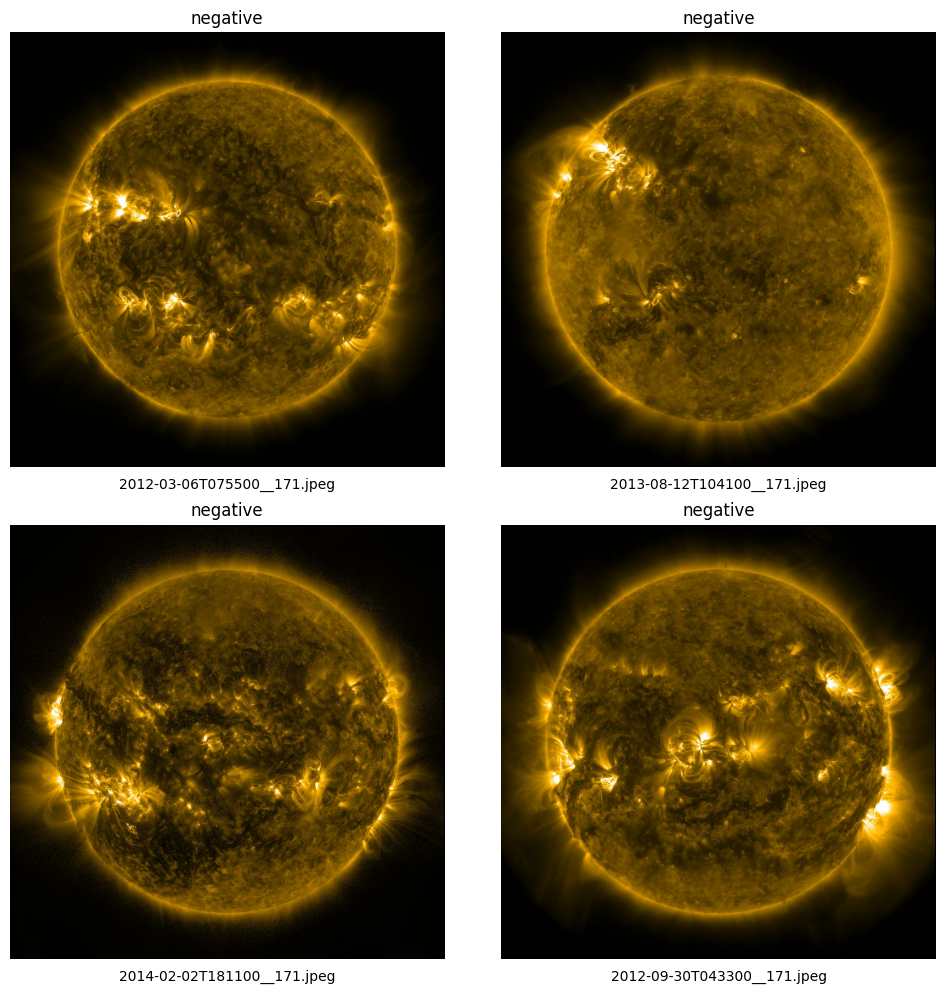

In [27]:
# Define the number of rows and columns in the subplot grid
num_rows, num_cols = 2, 2
num_images = num_rows * num_cols

# Create a figure for the subplots
plt.figure(figsize=(10, 10))

for i, (images, labels) in enumerate(data.take(num_images)):
    ax = plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.title(f'{class_names[int(labels[0])]}')
    plt.axis("off")

    # Extract the file name from the file path
    file_name = os.path.basename(data.file_paths[i])

    # Place the file name under the image
    plt.text(0.5, -0.05, file_name, fontsize=10, ha='center', transform=ax.transAxes)

plt.tight_layout()
plt.show()

### Scale the Data
Since these images are in an RGB format it is often very useful to normalize the images. To do this the images are divided by 255.

In [28]:
data = data.map(lambda x,y: (x/255, y))
data

<_MapDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [29]:
scaled_data_iterator = data.as_numpy_iterator()
batch = scaled_data_iterator.next()

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


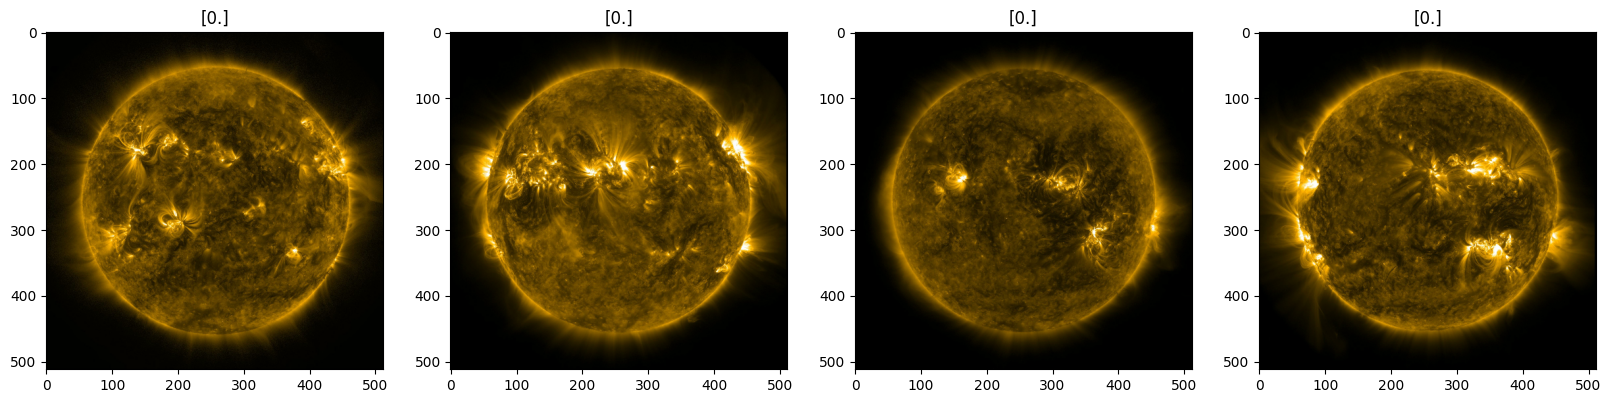

In [30]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

### Split Data

In [31]:
len(data)

18

In [32]:
train_size = int(len(data)*.7)
print('trainig batches:', train_size)
val_size = int(len(data)*.1)
print('validation batches:', val_size)
test_size = int(len(data)*.2)
print('test batches:', test_size)

trainig batches: 12
validation batches: 1
test batches: 3


Define the training, validation and testing data from batches:

In [33]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [34]:
type(train)

tensorflow.python.data.ops.take_op._TakeDataset

In [35]:
# Convert the dataset to a numpy iterator
train_iterator = train.as_numpy_iterator()

# Initialize counters
total_samples = 0
negative_samples = 0
positive_samples = 0

for batch in train_iterator:
    images, labels = batch
    total_samples += len(images)  # Count total samples in the batch
    negative_samples += (labels == 0).sum()  # Count negative samples (label 0)
    positive_samples += (labels == 1).sum()  # Count positive samples (label 1)

print("Total training samples:", total_samples)
print("Negative samples:", negative_samples)
print("Positive samples:", positive_samples)


Total training samples: 384
Negative samples: 315
Positive samples: 69


In [36]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / negative_samples) * (total_samples / 2.0)
weight_for_1 = (1 / positive_samples) * (total_samples / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.61
Weight for class 1: 2.78


In [37]:
train_iterator = train.as_numpy_iterator()
train_iterator

In [38]:
X_train = []
y_train = []

for batch in train_iterator:
    X_batch, y_batch = batch
    X_train.append(X_batch)
    y_train.append(y_batch)

# Convert the lists to NumPy arrays for further use
X_train = np.array(X_train)
y_train = np.array(y_train)


In [39]:
y_train.shape

(12, 32, 1)

In [40]:
# Convert the dataset to a numpy iterator
test_iterator = test.as_numpy_iterator()

# Initialize counters
total_samples = 0
negative_samples = 0
positive_samples = 0

for batch in test_iterator:
    images, labels = batch
    total_samples += len(images)  # Count total samples in the batch
    negative_samples += (labels == 0).sum()  # Count negative samples (label 0)
    positive_samples += (labels == 1).sum()  # Count positive samples (label 1)

print("Total testing samples:", total_samples)
print("Negative samples:", negative_samples)
print("Positive samples:", positive_samples)


Total testing samples: 96
Negative samples: 82
Positive samples: 14


## Model Architecture
### General Remarks

Since we deal with a very small dataset some preliminary considerations have to be mentioned:
* **Small datasets tend to overfit:** \\
One of the most relevant problems with ML models is the so-called Bias-Variance trade-off, or in other words the balance between over-simplification (high bias) and paying too much attention to the training set, such that the model doesn’t generalize well. If a combination of a low bias and high variance is present, one speaks of overfitting the data. On the other hand, if
the model shows a high bias and low variance the model underfits the data.
* **Using simple models:** \\
If only a limited amount of data is available, using a simple model architecture is often better suited compared to overly complex ones. Additionally, regularization techniques can help to avoid overfitting. Types of regularization techniques include modifying the loss function (e.g. L1/L2 Regularization), adjusting the training algorithm (e.g. dropout), or modifying the model input data based on the original dataset (e.g. K-fold cross-validation or data augmentation).
* **Combining models:** \\
Instead of having one complex model, combining a number of simple models could also help to reduce variance and improve generalization.


These considerations (and more) have to be made in advance to generate a useful model for a tiny dataset like the present one. Therefore, two models are presented here:
* a **simple binary classifier** model and
* the same model with additional **data augmentation**.

### Setup Data Augmentation

In [41]:
test_img_aug = batch[0]

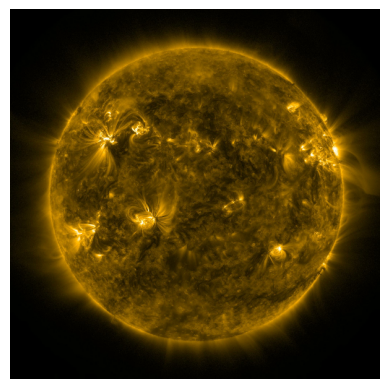

In [42]:
plt.axis('off')
plt.imshow(test_img_aug[0])

In [43]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("vertical", input_shape= input_shape),
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape= input_shape),
    #layers.experimental.preprocessing.RandomRotation(0.1, input_shape= input_shape),
  ]
)

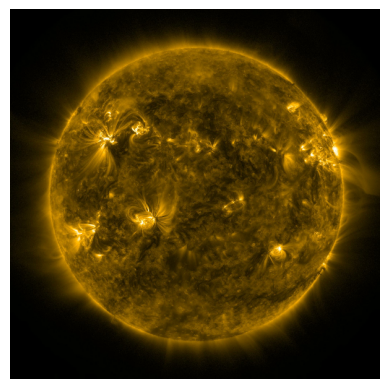

In [44]:
plt.axis('off')
plt.imshow(data_augmentation(test_img_aug)[0].numpy())

### Model Architecture
First, a simple model architecture was defined (by trail and error), consisting of three convolutional layers, a flatten layer, a dense and dropout layer, and finally, the output layer.

In [92]:
# # Model 2
binclass_model = Sequential([
    #data_augmentation,

    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.0001)),
    MaxPooling2D((2, 2)),
    #BatchNormalization(),

    Conv2D(32, (3,3), 1, activation='relu'),
    MaxPooling2D(),
    #BatchNormalization(),
    Conv2D(16, (3,3), 1, activation='relu'),
    BatchNormalization(),

    #Dropout(0.4),
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.0001)),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

After defining the model, it has to be compiled:

In [94]:
# Define a learning rate schedule function
from tensorflow.keras.callbacks import LearningRateScheduler
def lr_schedule(epoch, learning_rate):
    if epoch < 10:
        return learning_rate
    else:
        return learning_rate * 0.1  # Reduce the learning rate by a factor of 0.1 after 10 epochs

# Create a learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

In [95]:
opt = keras.optimizers.Adam(learning_rate=0.001)
binclass_model.compile( optimizer= opt, loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In summary, this compiled binary classification ML model, using the "Adam" optimizer, binary cross-entropy as the loss function, and monitoring the accuracy as the evaluation metric during training.

In detail, the compiled model has the following characteristics:
* `adam`: \\
  ''Adam'' is a popular optimization algorithm commonly used in ML for gradient-based optimization. It's well-suited for a wide range of tasks and is known for its efficiency. Here, the leaning rate is adjustable.
* `loss=tf.losses.BinaryCrossentropy()`: \\
  This defines the loss function used to measure how well the model is performing. In this case, it's using binary cross-entropy, which is a common choice for binary classification tasks. Binary cross-entropy measures the dissimilarity between the predicted probabilities and the actual binary labels, aiming to minimize this dissimilarity during training.
* `metrics=['accuracy']`: \\
   This parameter specifies the evaluation metric(s) to monitor during training. "Accuracy" is a standard metric for classification tasks. It calculates the ratio of correctly predicted instances to the total number of instances in the dataset and provides a measure of the model's classification performance.

Next, lets summarize the model in terms of its parameters and make an illustration of it:

In [96]:
binclass_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 510, 510, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 255, 255, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 253, 253, 32)      9248      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 126, 126, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 124, 124, 16)      4624      
                                                                 
 batch_normalization_9 (Bat  (None, 124, 124, 16)     

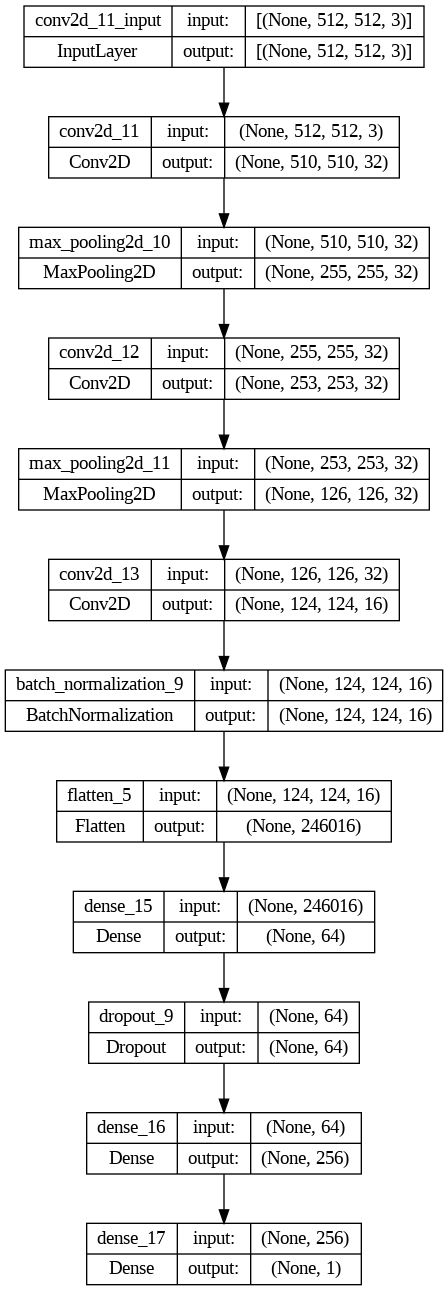

In [97]:
plot_model(binclass_model, to_file='02_sdo_binclass/models/bin_class_model.png', show_shapes=True, show_layer_names=True)

### Training
Now, that the moel is defined and compiled, we can start with training the model!

In [98]:
# Load the TensorBoard extension
# %load_ext tensorboard

In [99]:
# # Clear any logs from previous runs
# !rm -rf ./logs/

In [100]:
logdir=os.path.join(working_dir +'logs', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)
#early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [101]:
binclass_hist = binclass_model.fit(train, epochs=50, validation_data=val, callbacks=[tensorboard_callback, lr_scheduler]) #, early_stopping_callback])


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/50
12/12 [==============================] - 9s 446ms/step - loss: 1.9935 - accuracy: 0.6641 - val_loss: 0.6609 - val_accuracy: 0.8438 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/50
12/12 [==============================] - 7s 501ms/step - loss: 0.6699 - accuracy: 0.7370 - val_loss: 0.6728 - val_accuracy: 0.8125 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/50
12/12 [==============================] - 6s 478ms/step - loss: 0.5855 - accuracy: 0.7917 - val_loss: 0.6989 - val_accuracy: 0.7812 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/50
12/12 [==============================] - 7s 524ms/step - loss: 0.5247 - accuracy: 0.7995 - val_loss: 0.6687 - val_accuracy: 0.7812 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.0

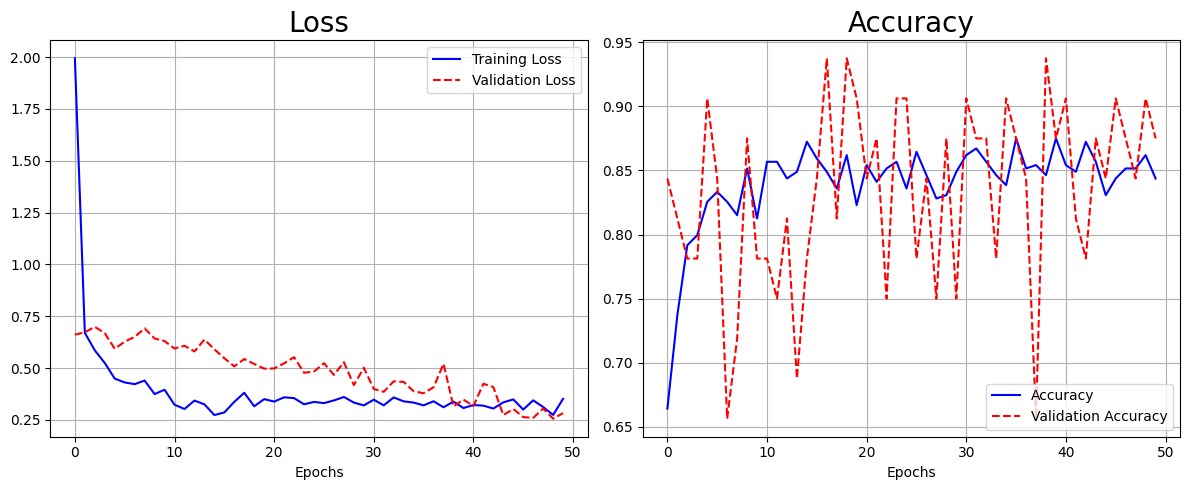

In [102]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# First subplot: Loss
ax1.plot(binclass_hist.history['loss'], color='blue', label='Training Loss')
ax1.plot(binclass_hist.history['val_loss'], color='red', linestyle='--', label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.grid(True)
ax1.set_title('Loss', fontsize=20)
ax1.legend(loc='upper right')

# Second subplot: Accuracy
ax2.plot(binclass_hist.history['accuracy'], color='blue', label='Accuracy')
ax2.plot(binclass_hist.history['val_accuracy'], color='red', linestyle='--', label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.grid(True)
ax2.set_title('Accuracy', fontsize=20)
ax2.legend(loc='lower right')

# Adjust spacing between subplots
plt.tight_layout()

# Save the merged plot
plt.savefig('02_sdo_binclass/models/2023-10-21_bin_class_combined.png')

# Display the merged graph
plt.show()


## Model Evaluation

To assess the model's performance on unseen data, one should have a separate test dataset. To evaluate the model on this dataset and compute metrics such as accuracy, precision, recall, and F1 score.

In [103]:
test_loss, test_accuracy = binclass_model.evaluate(test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


3/3 [==============================] - 3s 47ms/step - loss: 0.3037 - accuracy: 0.8646
Test Loss: 0.3037
Test Accuracy: 0.8646


In [104]:
val_loss, val_accuracy = binclass_model.evaluate(val)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

1/1 [==============================] - 3s 3s/step - loss: 0.2447 - accuracy: 0.9062
Validation Loss: 0.2447
Validation Accuracy: 0.9062


**Confusion Matrix and Classification Report:**

To understand how the model is performing in terms of true positives, true negatives, false positives, and false negatives, one can compute a confusion matrix and a classification report:

In [105]:
from sklearn.metrics import confusion_matrix, classification_report

# Generate predictions for the test dataset
test_predictions = binclass_model.predict(test)
test_predictions = (test_predictions > 0.5).astype(int)  # Convert probabilities to binary predictions

# Extract labels from the test dataset
test_labels = np.concatenate([y for x, y in test.as_numpy_iterator()], axis=0)

# Compute confusion matrix
cm = confusion_matrix(test_labels, test_predictions)
print("\nConfusion Matrix:\n")
print(cm)

# Generate a classification report
report = classification_report(test_labels, test_predictions)
print("\nClassification Report:\n")
print(report)


3/3 [==============================] - 3s 42ms/step

Confusion Matrix:

[[75  2]
 [17  2]]

Classification Report:

              precision    recall  f1-score   support

         0.0       0.82      0.97      0.89        77
         1.0       0.50      0.11      0.17        19

    accuracy                           0.80        96
   macro avg       0.66      0.54      0.53        96
weighted avg       0.75      0.80      0.75        96



The confusion matrix and classification report provide valuable insights into the performance of the binary classification model.

From the results, one can see:

- The confusion matrix shows that there are 24 true negatives (TN), 1 false positive (FP), 7 false negatives (FN), and 0 true positives (TP).

- The classification report provides additional metrics such as precision, recall, and F1-score for each class (0 and 1) as well as the overall accuracy.

- It appears that the model has achieved high precision for class 0 (negative) but low recall, and it has not correctly identified any instances of class 1 (positive). The overall accuracy is 0.75.

Based on these results, one may want to consider further optimizing the model, adjusting the threshold for binary classification, or exploring different evaluation metrics based on the specific requirements of your application.

**ROC Curve and AUC:**

Since this is a binary classification and we are interested in assessing the trade-off between true positive rate and false positive rate, one can plot the Receiver Operating Characteristic (ROC) curve and calculate the Area Under the Curve (AUC):

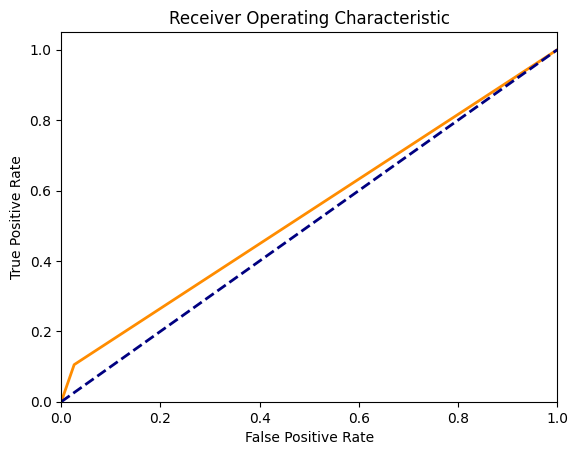

AUC: 0.5396


In [106]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(test_labels, test_predictions)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.show()

# Calculate AUC
auc = roc_auc_score(test_labels, test_predictions)
print(f"AUC: {auc:.4f}")


**Visualize Predictions:**

Finally, one can also visualize the model predictions on the test dataset to gain insights into its performance.

Note: re-run the cell for different images

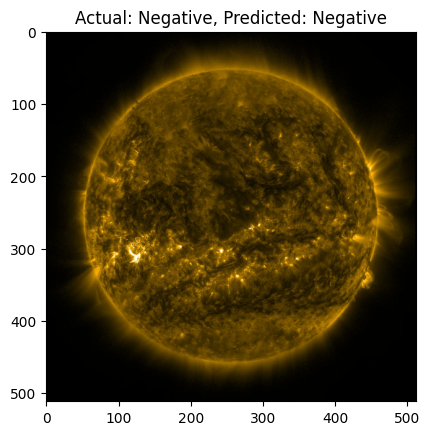

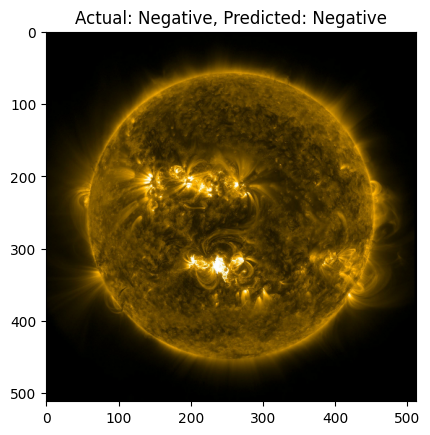

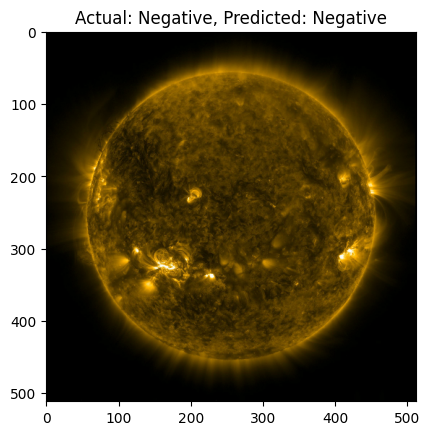

In [107]:
import random
import matplotlib.pyplot as plt

# Convert the test dataset to a NumPy array for indexing
test_data = np.array([x for x, _ in test.as_numpy_iterator()])
test_labels = np.concatenate([y for _, y in test.as_numpy_iterator()], axis=0)

# Define labels for better readability
label_names = {0: "Negative", 1: "Positive"}

num_samples = len(test_data)
sample_count = min(5, num_samples)  # Choose up to 5 random samples or all available samples

if num_samples > 0:
    sample_indices = random.sample(range(num_samples), sample_count)

    for idx in sample_indices:
        image_batch = test_data[idx]  # Extract the image batch
        label = test_labels[idx]
        prediction = test_predictions[idx]

        # Choose a single image from the batch (e.g., the first image)
        single_image = image_batch[0]

        plt.figure()
        if single_image.shape[-1] == 3:
            plt.imshow(single_image)  # Display an RGB image
        elif single_image.shape[-1] == 1:
            plt.imshow(single_image[:, :, 0], cmap='gray')  # Display a grayscale image

        # Display labels as "Negative" or "Positive"
        actual_label = label_names[int(label)]
        predicted_label = label_names[int(prediction)]

        plt.title(f"Actual: {actual_label}, Predicted: {predicted_label}")
        plt.show()
else:
    print("Test dataset is empty. There are no samples to display.")


**Save the Model**


In [108]:
binclass_model.save(os.path.join('02_sdo_binclass/models/','imageclassifier_da.h5'))


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(




---


## Conclusion

* TBD
